# BDA project "Pump It Up"

- Анастасия Барковая
- Варвара Михайлова
- Анна Снигирева

# 1. Проблема

В соответствии с [water.org ](https://water.org ), 4 миллиона человек в Танзании не имеют доступа к улучшенному источнику безопасной воды.

Люди, живущие в таких условиях, тратят значительное количество времени на поездки на большие расстояния, чтобы набрать воды в пунктах сбора воды.

Точное предсказание того, функционируют насосы или нет, действительно важно, поскольку люди подвергаются риску ухудшения здоровья или даже смерти от обезвоживания.

![image.png](attachments/image.png)

Используя данные Taarifa и Министерства водного хозяйства Танзании, мы должны понимать, какие насосы исправны, какие нуждаются в некотором ремонте, а какие вообще не работают. Прогноз будет основан на ряде переменных, касающихся того, какой тип насоса работает, когда он был установлен и как им управляют. Четкое понимание того, какие пункты водоснабжения выйдут из строя, может улучшить операции по техническому обслуживанию и обеспечить доступность чистой питьевой воды для населения по всей Танзании.

[Ссылка на конкурс](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table )

# 2. Подгрузка датасета

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
try:
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs
except:
    !pip install cartopy
    import cartopy.feature as cfeature
    import cartopy.crs as ccrs

In [2]:
X = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv", index_col=0)
X_pred = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv", index_col=0)
y = pd.read_csv("dataset/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv", index_col=0)
assert (X.index == y.index).all()

In [3]:
pd.options.display.max_columns = 41
y.head(5)

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


Посмотрим, сколько всего количественных и категориальных признаков

In [4]:
cat_features = 0
numeric_features = 0
for column, tp in X.dtypes.items():
    if str(tp) == 'object':
        cat_features += 1
    else:
        numeric_features += 1
print(f'There are {cat_features} categorial features and {numeric_features} numeric features.')

There are 30 categorial features and 9 numeric features.


Посмотрим, сколько N/A признаков

In [5]:
y.isna().sum()

status_group    0
dtype: int64

In [6]:
categorial_nan_count = X.select_dtypes(include=['object']).isna().sum()
numeric_nan_count = X.select_dtypes(exclude=['object']).isna().sum()
print(f'NaN in Categorial:\n{(categorial_nan_count != 0).sum()}')
print(f'NaN in Numerics:\n{(numeric_nan_count != 0).sum()}')


NaN in Categorial:
7
NaN in Numerics:
0


Как видим, NaN встречается только в категориальных признаках, поэтому заменим строкой "None"

In [7]:
dtypes = X.dtypes
for column, tp in dtypes.items():
    if str(tp) == 'object':
        X[column] = pd.Series(X[column], dtype="string")

In [8]:
X.fillna(value="None", inplace=True)
X_pred.fillna(value="None", inplace=True)

Зависимости между численными признаками:

In [9]:
df = pd.merge(X, y, on='id', how='inner')

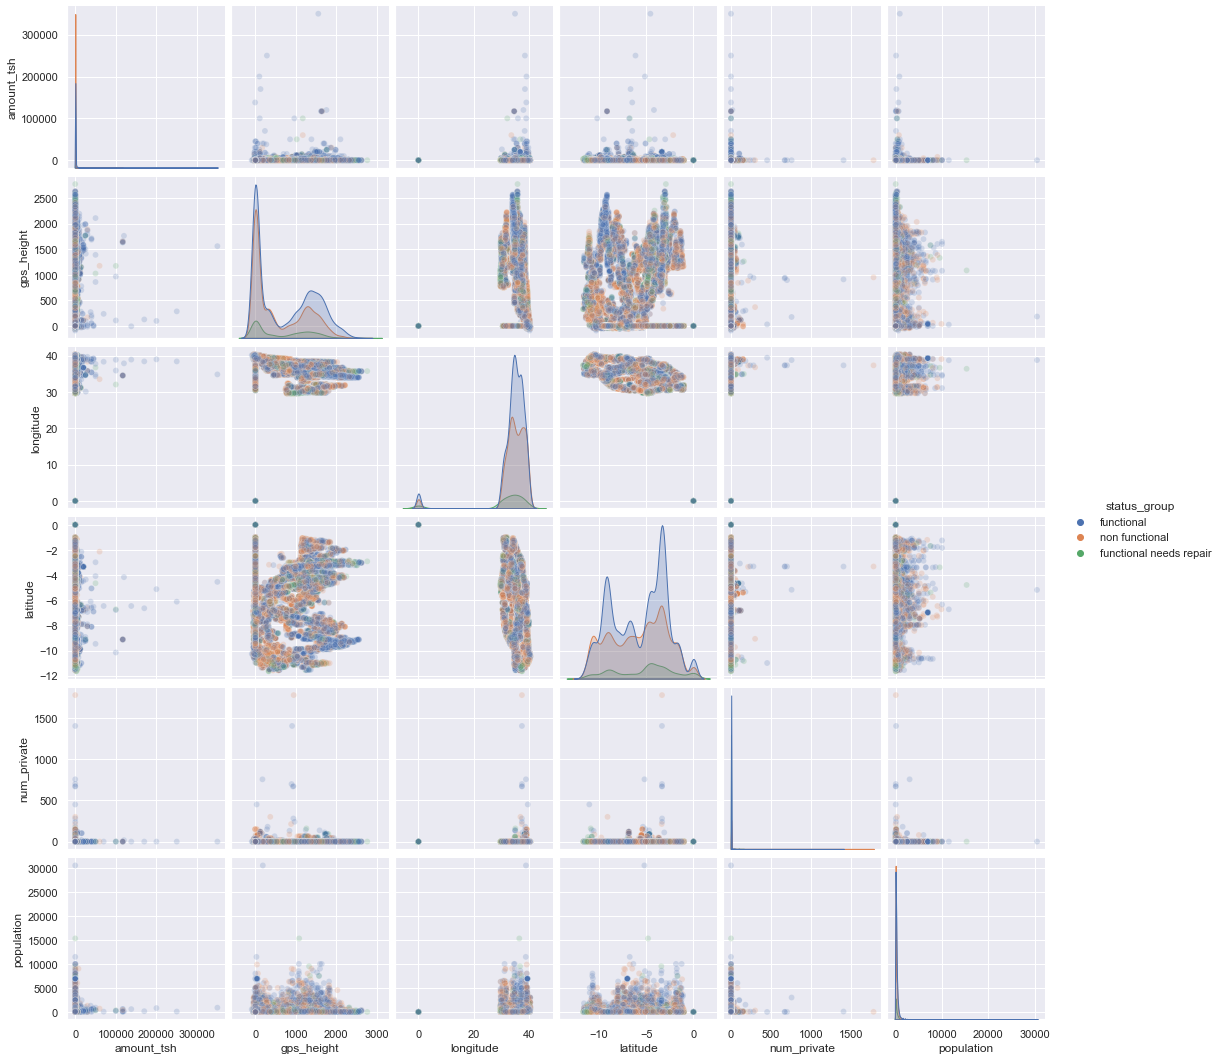

In [10]:
sns.pairplot(df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'status_group']],
             hue='status_group', kind='scatter', plot_kws={'alpha' : 0.2})
plt.show()

Мы видим много выбросов, поэтому аккуратно избавимся от них

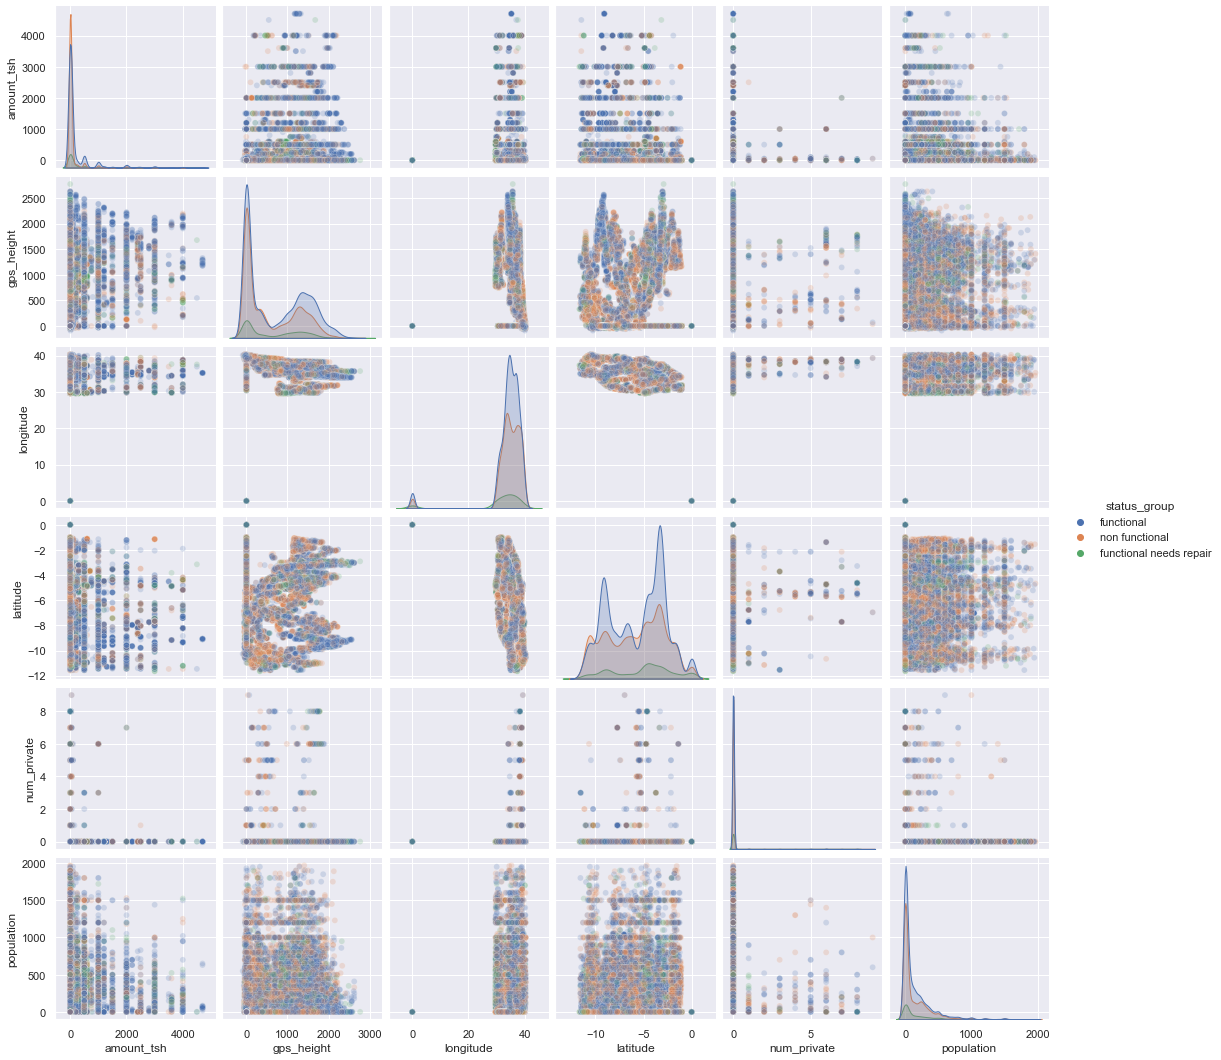

In [11]:
mask = (df['amount_tsh'] < 5000) & (df['num_private'] < 10) & (df['population'] < 2000)
sns.pairplot(df[['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'status_group']][mask],
             hue='status_group', kind='scatter', plot_kws=dict(alpha=0.2))
plt.show()

Составим общую таблицу, соединив X и y

In [12]:
df = df[(df['amount_tsh'] < 5000) & (df['num_private'] < 10) & (df['population'] < 2000)]

# 3. Исследование датасета

### Посмотрим, какое распределение насосов каждого типа по глубине

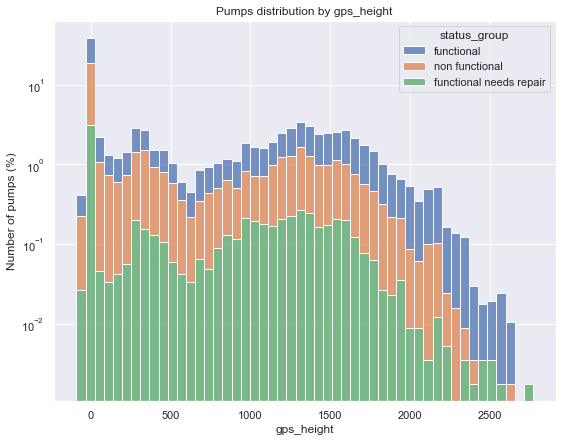

In [13]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.histplot(data=df, x="gps_height", hue="status_group", stat='percent', bins=50, multiple="stack");
plt.yscale('log')
plt.ylabel('Number of pumps (%)');
plt.title('Pumps distribution by gps_height');
plt.show()

### Посмотрим расположение функционирующих колодцев на карте

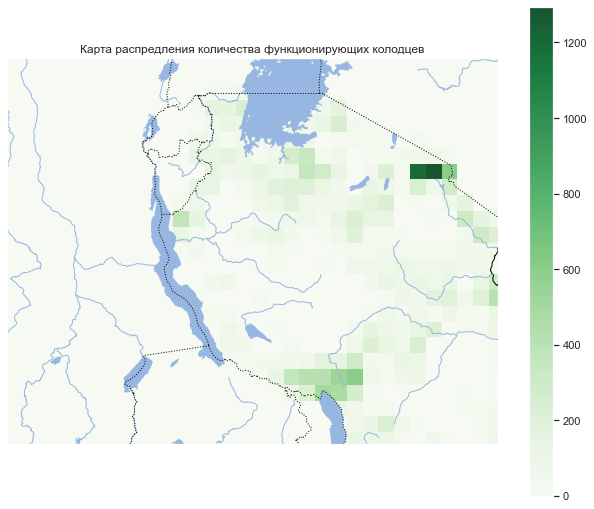

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(11, 9))
min_lon = 25  # Минимальная долгота
max_lon = 39  # Максимальная долгота
min_lat = -11  # Минимальная широта
max_lat = 0   # Максимальная широта
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

km_to_degres = lambda km: km/111

# Heatmap для функционирующих колодцев
func_heatmap = sns.histplot(data=df[df['status_group'] == 'functional'], x='longitude', y='latitude',
            fill=True, cmap='Greens', ax=ax, alpha=0.9, 
                           cbar=True, binwidth = km_to_degres(50), thresh=None, norm=None)

ax.set_title('Карта распредления количества функционирующих колодцев')
plt.show()


### Рассмотрим cуммарное количество воды по географическим локациям:

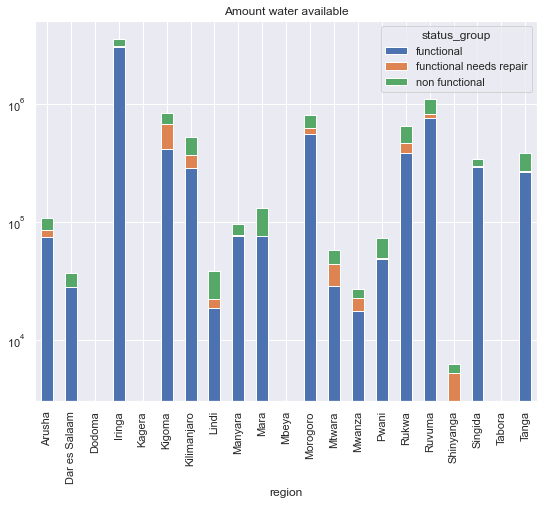

In [15]:
fig, ax = plt.subplots(figsize=(9, 7))


_data = df.groupby(["region", "status_group"])['amount_tsh'].sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
#plt.ylabel('Number of pumps (%)');
plt.title('Amount water available');
plt.show()

### Видно, что от местности к местности, значения меняются. Поэтому рассмотрим количество воды в насосах на душу населения рядом с насосом в зависимости от региона

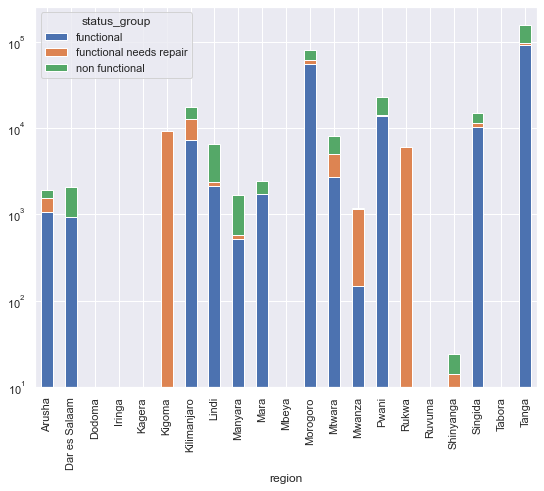

In [16]:
fig, ax = plt.subplots(figsize=(9, 7))

df['amount_per_one'] = df['amount_tsh']/df['population']
_data = df.groupby(["region", "status_group"])
_data = _data.amount_per_one.sum().unstack()
_data.plot(kind='bar', stacked=True, ax=ax);
plt.yscale('log')
plt.show()

### Посмотрим на основные источники водоснабжения

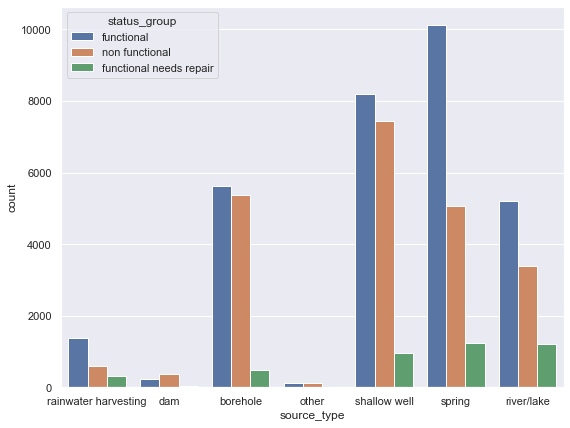

In [17]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.countplot(data = df, x = 'source_type', hue = 'status_group')
plt.show()

Самыми популярными являются родник и неглубокий колодец. Для родников преобладают функционирующие насосы, в то время как для колодцев число функционирующих и нефункционирующих примерно одинаково.

### Определим зависимость функционирования насоса от платежа за воду

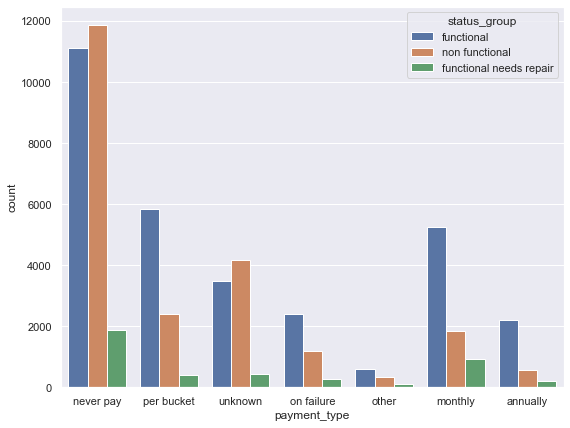

In [18]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.countplot(data = df, x = 'payment_type', hue = 'status_group')
plt.show()

Из графика видно, если оплачивать воду, то часть средств будут уходить на обслуживание точки, и, следовательно, вероятность функционирования точки будет выше.

### Посмотрим распредление качества воды исходя из доступного количества воды

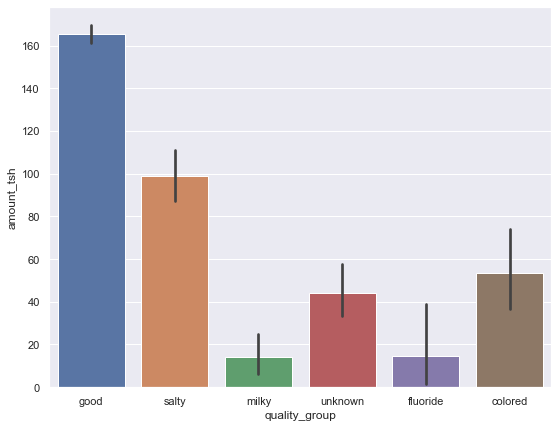

In [19]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.barplot(data=df, x='quality_group', y='amount_tsh')
plt.show()

Можно видеть, что больше всего доступной воды относится к фторсодержащей и хорошей по качеству. Это говорит о том, что большинство воды, которую можно добыть в этих точках, можно использовать как питьевую.

### Рассмотрим распределение функциональных и нефункциональных колодцев среди всего населения Танзании

In [20]:
populations = df.groupby('status_group')['population'].sum()
wells = populations.keys().to_list()
data = populations.to_list()

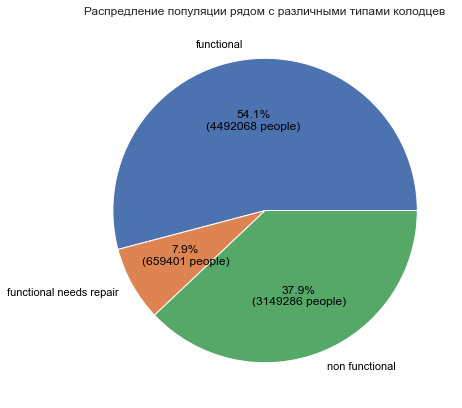

In [21]:
fig, ax = plt.subplots(figsize=(9, 7), subplot_kw=dict(aspect="equal"))

def pct(p,allvals):
    absolute = int(np.round(p/100.*np.sum(allvals)))
    return f"{p:.1f}%\n({absolute:d} people)"

plt.pie(data, labels=wells, autopct=lambda p: pct(p, data), textprops=dict(color="black"))

plt.title("Распредление популяции рядом с различными типами колодцев")

plt.show()

Из представленной круговой диаграммы видно, что почти половина населения Танзании не имеет доступа к полноценно функционирующим колодцам.

### График, отражающий зависимость колодцев с хорошей водой от общего количества функционирующих колодцев, а также от года постройки колодца

In [22]:
years = []
for i,r in df.iterrows():
    years.append(r.construction_year)
years = np.array(years)
years = np.unique(years)
years = np.delete(years,0)

In [23]:
res1 = []
for i in years:
    mask = (df.construction_year == i) & (df.status_group == 'functional') & (df.quality_group == 'good')
    res1.append(len(df[mask]))

In [24]:
res2 = []
for i in years:
    mask = (df.construction_year == i) & (df.status_group == 'functional')
    res2.append(len(df[mask]))

In [25]:
tdf = pd.DataFrame()

tdf['years'] = years
tdf['functional_wells'] = np.array(res2) / len(df)
tdf['good_water_wells'] = np.array(res1) / np.array(res2)

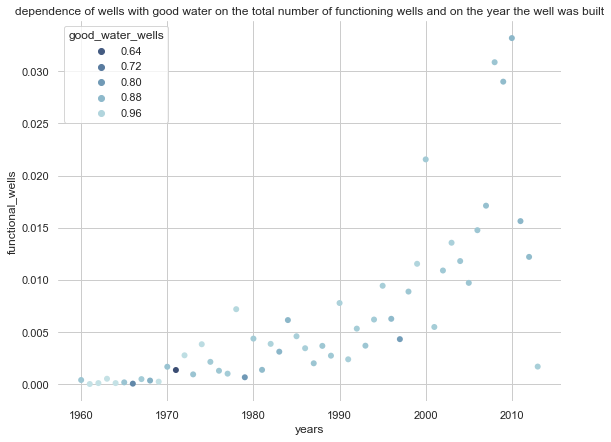

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(9, 7))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="years", y="functional_wells",
                hue="good_water_wells",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=tdf, ax=ax)
plt.title('dependence of wells with good water on the total number of functioning wells and on the year the well was built')
plt.show()

Из графика видно, что с течением времени доля функционирующих колодцев с хорошей водой увеличивалось.

### Рассмотрим распределние добычи воды на декаду

In [27]:
a = ['gravity','handpump','motorpump','rope pump','submersible','wind-powered']
res_0 = []
res_1 = []
res_2 = []
res_3 = []
res_4 = []
res_5 = []
res = [res_0,res_1,res_2,res_3,res_4,res_5]
for i in years:
    for j in a:
        mask = (df.construction_year == i) & (df.status_group == 'functional') & (df.extraction_type_class == f'{j}')
        ind = a.index(j)
        res[ind].append(len(df[mask]))
tdf3 = pd.DataFrame()
tdf3['years'] = years
tdf3['gravity'] = res_0
tdf3['handpump'] = res_1
tdf3['motorpump'] = res_2
tdf3['rope_pump'] = res_3
tdf3['submersible'] = res_4
tdf3['wind_powered'] =res_5

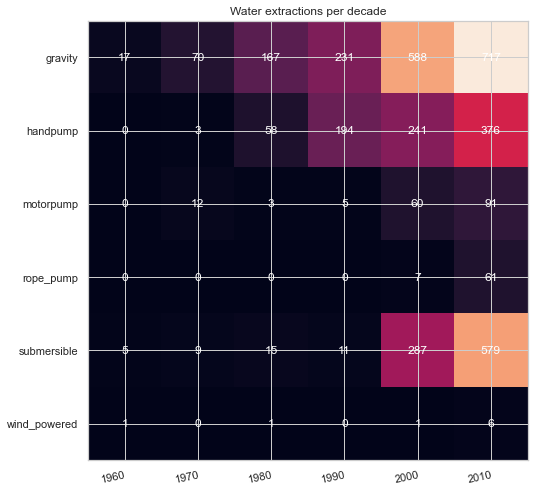

In [28]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


extraction_types = ["gravity", "handpump", "motorpump", "rope_pump",
              "submersible", "wind_powered"]
year = []
indexies = []
for i in years:
    if str(i)[-1] == '0':
        year.append(i)
        indexies.append(list(years).index(i))

harvest = np.array([[res_0[i] for i in indexies],
                    [res_1[i] for i in indexies],
                    [res_2[i] for i in indexies],
                    [res_3[i] for i in indexies],
                    [res_4[i] for i in indexies],
                    [res_5[i] for i in indexies]])


fig, ax = plt.subplots(figsize=(9, 7))

im = ax.imshow(harvest)

ax.set_xticks(np.arange(len(year)), labels=year)
ax.set_yticks(np.arange(len(extraction_types)), labels=extraction_types)

plt.setp(ax.get_xticklabels(), rotation=12, ha="right",
         rotation_mode="anchor")


for i in range(len(extraction_types)):
    for j in range(len(year)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Water extractions per decade")
fig.tight_layout()
plt.show()

# 4. Статистические тесты. Проверка гипотез.

Попробуем применить статистические тесты для сравнения долей функционирующих колодцев по типу оплаты колодца. 
1. Посмотрим, зависит ли наличие оплаты от функционирования

Гипотеза H0: доли функционирующих среди неоплаченных и оплаченных колодцев равны

In [124]:
_df = df[(df.payment_type != 'unknown') & (df.payment_type != 'other') & (df.status_group != 'functional needs repair')]
df1 = _df[(_df.status_group == 'functional')]
m1 = sum(df1.payment_type == 'never pay')
n1 = sum(_df.payment_type == 'never pay')
m2 = sum(df1.payment_type != 'never pay')
n2 = sum(_df.payment_type != 'never pay')

In [125]:
# доля функционирующих среди неоплачиваемых
p1 = m1 / n1
# доля функционирующих среди оплачиваемых
p2 = m2 / n2
#двувыборочные тест для долей
p = (m1 + m2) / (n1 + n2)
s = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
z = (p1 - p2) / s

In [204]:
p_val = 2 * stats.norm.sf(np.abs(z))
p_val, z

(0.0003285677406985009, -3.591668412208754)

Видим большую Z-статистику, что свидетельствуют о сильном различии долей функционирующих колодцев по типу оплату. Можно сделать вывод, что доля неоплачиваемых функционирующих колодцев сильно меньше чем оплачиваемых

2. Мы предполагаем, что старые колодцы в среднем производят меньше воды, чем новые. Сравним среднее количество воды от 1го колодца построенного до 1980 года и после

In [199]:
_df = df[(df.construction_year > 0) & (df.status_group == 'functional')]
#выделили все которые до 1980 и после
sample_1 = _df[_df.construction_year <= 1980]['amount_tsh']
sample_2 = _df[_df.construction_year > 1980]['amount_tsh']

In [200]:
sd1 = np.std(sample_1)
sd2 = np.std(sample_2)

#находим z - статистику
t1 = np.mean(sample_1) - np.mean(sample_2)
t2 = np.sqrt(sd1 ** 2 / len(sample_1) + sd2 ** 2 / len(sample_2))
z = t1 / t2
p_val = 2 * stats.norm.sf(abs(z))
z, pval = stats.ttest_ind(sample_1, sample_2)
p_val, z

(0.5683214030655369, 0.5583579828514988)

Мы уже не можем увидеть статистические отличия. Найдем год, по которому уже наблюдается разница

In [201]:
pvals = []
years = []
zs = []
#просто переберем все года и построим соответствующие статистики
for year in _df.construction_year.unique():
    sample_1 = _df[_df.construction_year < year]['amount_tsh']
    sample_2 = _df[_df.construction_year >= year]['amount_tsh']
    if (len(sample_1) > 100 and len(sample_2) > 100):
        z, p_val = stats.ttest_ind(sample_1, sample_2)
        zs.append(z)
        pvals.append(p_val)
        years.append(year)

Посмотрим, как меняется pval в зависимости от года

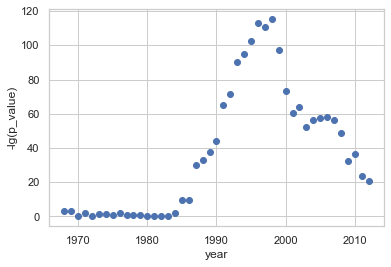

In [202]:
plt.scatter(years, -np.log10(pvals))
plt.xlabel('year')
plt.ylabel('-lg(p_value)')
plt.show()

Видно, что после 1990 года наблюдаются статистически значимые отличия между функционирующими колодцами, построенными до и после

3. Посмотрим, есть ли различие в долях функционирующих колодцов по их типу

Построим таблицу

In [132]:
_df = df[(df['status_group'] != 'functional needs repair') & (df['extraction_type_group'] != 'other') & 
        (df['extraction_type_group'] != 'other handpump') & (df['extraction_type_group'] != 'other motorpump')]
crosstab = pd.crosstab(_df.status_group, _df.extraction_type_group)
crosstab

extraction_type_group,afridev,gravity,india mark ii,india mark iii,mono,nira/tanira,rope pump,submersible,swn 80,wind-powered
status_group,,,,,,,,,,
functional,1140,15341,1351,43,1015,5356,291,3083,2052,47
non functional,511,7903,842,51,1630,2061,135,2493,1354,55


In [133]:
#критерий хи-квадрат
res = stats.chi2_contingency(crosstab) 
res.statistic, res.pvalue

(1260.3029406856213, 1.1575020942260596e-265)

Такое значение свидетельствуют о том, что существуют значительные статистические различия между типами насоса

Так же проверим различие по региону

In [138]:
_df = df[(df['quality_group'] != 'unknown') & (df['status_group'] != 'functional')]
crosstab = pd.crosstab(_df.quality_group, _df.region)
crosstab

region,Arusha,Dar es Salaam,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga
quality_group,,,,,,,,,,,,,,,,,,,,,
colored,0,0,15,1,17,4,1,7,4,5,54,34,14,4,11,2,3,30,4,30,3
fluoride,30,2,0,0,0,1,0,0,4,0,7,2,1,0,1,0,0,5,1,0,2
good,993,184,964,1072,1457,1378,1660,536,431,765,2154,1349,914,1190,862,859,1098,1626,546,895,658
milky,0,1,4,0,14,7,0,23,1,5,5,5,18,30,7,4,0,199,5,32,3
salty,8,137,197,8,29,10,28,353,120,229,38,328,205,172,117,64,5,194,63,134,292


In [139]:
res = stats.chi2_contingency(crosstab) 
res.statistic, res.pvalue

(4584.221473589049, 0.0)

Теперь найдем те регионы, в которых есть сильно различие по сравнению с общим между нехорошими и хорошими в пользу нехороших

In [206]:
_df = df[(df['quality_group'] != 'unknown') & (df['status_group'] != 'functional')]
bad_regions = []

#смотрим на общую долю хороших колодцев
m2 = sum(_df.quality_group == 'good')
n2 = len(_df)
p2 = m2 / n2 #--берем эту вероятность за опорную

for region in _df.region.unique():
    
    #смотрим на долю хороших колодцев в соответствующем регионе
    df1 = _df[(_df.region == region)]
    m1 = sum(df1.quality_group == 'good')
    n1 = len(df1)
    p1 = m1 / n1
    
    #предполагаем что эти доли равны
    
    s = np.sqrt(p2 * (1 - p2) / n1)
    z = (p1 - p2) / s
    p_val = 2 * stats.norm.sf(abs(z))
    if p_val < 0.05 and z < 0:
        print(region, p_val, z)
        bad_regions.append(region)

Mtwara 2.324587801246689e-12 -7.013482062901114
Shinyanga 7.991446691831508e-22 -9.600038630591323
Tabora 2.365034803001219e-05 -4.227308335487322
Tanga 8.866827361390117e-58 -16.02273139087478
Mara 3.1877317920172383e-21 -9.456385107542879
Morogoro 1.2308270040803296e-21 -9.555420799980197
Dodoma 2.167032693693704e-06 -4.737188793074995
Lindi 1.9593478015430886e-136 -24.861144465988808
Manyara 6.526271658422378e-11 -6.531158890521152
Dar es Salaam 1.2057293667024247e-54 -15.567750834473737


Видим, что у региона Lindi самые худшие показатели качества воды среди работающих колодцев

# 5. Обучение

обозначим классы номерами

In [142]:
#просто занумеруем
class_labels = [
    "functional",
    "non functional",
    "functional needs repair"
]

label_to_id = {class_labels[i]: i for i in range(len(class_labels))}
y["class"] = y["status_group"].apply(lambda x: label_to_id[x])

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#разделили на тестовую и тренировочную выборку, размер тренировчоной 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=239, shuffle=True, stratify=y)

y_train = y_train["class"].values
y_test = y_test["class"].values
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (47520, 39)
y_train shape: (47520,)
X_test shape: (11880, 39)
y_test shape: (11880,)


Мы должны удалить / добавить некоторые признаки, преобразовать все наши категориальные и числовые функции в реальные значения, чтобы использовать их для обучения.

Давайте начнем с добавления и удаления некоторых функций.

Функции, которые мы добавляем:

- `working_days`: количество дней, в течение которых насос работает.
- `water_per_person`: значение, равное `amount_tsh`/max(10, `население`). Значение: среднее количество воды на человека.
- `person_per_water`: значение, равное `population`/max(10, `amount_tsh`). Значение: среднее количество людей на 1 единицу воды.

Функции, которые мы отбрасываем:

- `date_recorded`: мы использовали информацию об этом
- `quantity_group`: существует точно такой же столбец `quantity`
- `recorded_by`: все значения в этом столбце одинаковы

Также у нас есть информация примерно о тех же столбцах (например, `region`/`region_code`) или столбцах с приблизительно всеми значениями, равными $0$ (например, `num_private`). Но мы попытались отказаться от них, и качество стало немного хуже, поэтому мы решили не отказываться от них.

In [144]:
import datetime


def calculate_additional_features(X):
    X = X.copy()
    
    #функция которая вычисляет, сколько дней проработал колодец
    def calculate_working_days(row):
        if row[1] == 0:
            return 0
        date_recorded = datetime.datetime.strptime(row[0], "%Y-%m-%d").date()
        date_launched = datetime.datetime.strptime(f'{row[1]}-01-01', "%Y-%m-%d").date()
        return (date_recorded - date_launched).days
    X['working_days'] = X[['date_recorded', 'construction_year']].apply(calculate_working_days, axis=1)
    
    #функция которая вычисляет количесвто воды на человека
    def calculate_water_per_person(row):
        return min(10, row[0] / (max(row[1], 10)))
    
    #наоборот
    def calculate_person_per_water(row):
        return min(100, row[1] / (max(row[0], 10)))
    X['water_per_person'] = X[['amount_tsh', 'population']].apply(calculate_water_per_person, axis=1)
    X['person_per_water'] = X[['amount_tsh', 'population']].apply(calculate_person_per_water, axis=1)
    
    #удалили ненужные фичи
    X.drop(labels=['quantity_group',
                   #'subvillage',
                   #'ward',
                   #'num_private',
                   #'region_code',
                   'date_recorded',
                   'recorded_by'], axis=1, inplace=True)
    
    return X

In [145]:
X_full = calculate_additional_features(X)
X_train_full = calculate_additional_features(X_train)
X_test_full = calculate_additional_features(X_test)
X_pred_full = calculate_additional_features(X_pred)

Далее нужно что-то сделать с категориальными и численными признаками. Во-первых, применим OneHotEncoder к каждому категориальному признаку. Классы с частотой менее 3% будут объединены в один класс. Во-вторых, стандартиризуем численные признаки

In [146]:
MAX_UNIQUE = 30

nunique = X_full.nunique()
dtype = X_full.dtypes

numeric_features = []
one_hot_features = []

#смотрим какой тип признака и определяем его в соответствующую колонку
for column, tp in dtype.items():
    if str(tp) == 'string':
        one_hot_features.append(column)
    elif str(tp) == 'int64':
        if nunique[column] <= MAX_UNIQUE:
            one_hot_features.append(column)
        else:
            numeric_features.append(column)
    else:
        numeric_features.append(column)
        
print(f'One hot features: {one_hot_features}\n')
print(f'Numeric features: {numeric_features}\n')

One hot features: ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

Numeric features: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'population', 'construction_year', 'working_days', 'water_per_person', 'person_per_water']



In [147]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#создаем Pipeline.Это для удобной работы
transformer = Pipeline([
    ('transform', ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=0.03), one_hot_features),
        ('scale', StandardScaler(), numeric_features),
    ], sparse_threshold=0))
])

In [148]:
# преобразуем данные
transformer.fit(X_full)

Pipeline(steps=[('transform',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                min_frequency=0.03),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'region_code',
                                                   'district_code', 'lga',
                                                   'ward', 'public_meeting',
                                                   'scheme_management',
                                                   'scheme_name', 'permit',
                                                   'extraction_type',
                                                   'extraction_type_grou...
                                                   'management_group',
                                                   'payment', 'payment_type',
                                                   'water_quality',
                                                   'quality_group', 'quantity',
                                                   'source', 'source_type',
                                                   'source_class',
                                                   'waterpoint_type',
                                                   'waterpoint_type_group']),
                                                 ('scale', StandardScaler(),
                                                  ['amount_tsh', 'gps_height',
                                                   'longitude', 'latitude',
                                                   'num_private', 'population',
                                                   'construction_year',
                                                   'working_days',
                                                   'water_per_person',
                                                   'person_per_water'])]))])

In [149]:
X_full_t = transformer.transform(X_full)
X_train_t = transformer.transform(X_train_full)
X_test_t = transformer.transform(X_test_full)
X_pred_t = transformer.transform(X_pred_full)
y_full_t = y["class"].values
y_train_t = y_train
y_test_t = y_test

In [150]:
X_full_t.shape, X_train_t.shape

((59400, 174), (47520, 174))

Итак, мы имеем целых 174 признака!

Обучим модель с помощью логистической регрессии

In [151]:
from sklearn.linear_model import LogisticRegression

#задаем модель и обучаем
model = LogisticRegression(max_iter=5000)
model.fit(X_train_t, y_train_t)

LogisticRegression(max_iter=5000)

Посчитаем accuracy на тестовой и тренировочной выборке

In [152]:
from sklearn.metrics import accuracy_score

y_pred_train_t = model.predict(X_train_t)
y_pred_test_t = model.predict(X_test_t)
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train_t, y_pred_train_t)}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test_t, y_pred_test_t)}')

Accuracy на тренировочной выборке: 0.7417718855218856
Accuracy на тестовой выборке: 0.7441077441077442


Проведем кросс-валидацию:

In [153]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(max_iter=5000), X_full_t, y_full_t, scoring='accuracy', cv=5)
print(f'Accuracy: {scores.mean()} +- {scores.std()}')

Accuracy: 0.7407407407407407 +- 0.0031301362691975995


посмотрим, какой признак больше всего влияет на accuracy

In [160]:
features = []
scores = []
for feature in one_hot_features + numeric_features:
    S_full = X_full.copy()
    S_full[feature] = np.zeros_like(feature)
    ohf = one_hot_features.copy()
    nf = numeric_features.copy()
    fs = ohf if feature in ohf else nf
    fs.remove(feature)
    transformer = Pipeline([
    ('transform', ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=0.03), ohf),
        ('scale', StandardScaler(), nf),
    ], sparse_threshold=0))
    ])
    transformer.fit(S_full)
    S_full_t = transformer.transform(S_full)
    score = cross_val_score(LogisticRegression(max_iter=5000), S_full_t, y_full_t, scoring='accuracy', cv=2).mean()
    features.append(feature)
    scores.append(score)
    print(f'feature: {feature}, accuracy: {score}')

feature: funder, accuracy: 0.74003367003367
feature: installer, accuracy: 0.7388047138047138
feature: wpt_name, accuracy: 0.7401851851851852
feature: basin, accuracy: 0.7387542087542087
feature: subvillage, accuracy: 0.7401346801346802
feature: region, accuracy: 0.7399158249158249
feature: region_code, accuracy: 0.740016835016835
feature: district_code, accuracy: 0.737979797979798
feature: lga, accuracy: 0.7398821548821549
feature: ward, accuracy: 0.7401010101010101
feature: public_meeting, accuracy: 0.7396127946127946
feature: scheme_management, accuracy: 0.7405892255892257
feature: scheme_name, accuracy: 0.7399158249158249
feature: permit, accuracy: 0.7398653198653198
feature: extraction_type, accuracy: 0.7386531986531987
feature: extraction_type_group, accuracy: 0.7401010101010101
feature: extraction_type_class, accuracy: 0.7406060606060606
feature: management, accuracy: 0.736986531986532
feature: management_group, accuracy: 0.7393602693602693
feature: payment, accuracy: 0.740101010

In [167]:
features[np.argmin(scores)], min(scores) # "-- этот признак повлиял больше всех"

('quantity', 0.6942087542087543)